In [1]:
"""
I needed to install pyprotocols, which needed git clone https://github.com/pdollar/coco.git
to be cloned and "make" the pythonapi, which needed make to be installed, which needed apt-get update
check https://github.com/cocodataset/cocoapi/issues/8
and https://askubuntu.com/questions/192645/make-command-not-found
"""
from gluoncv import data, utils
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Running the tutorial on mscoco
train_dataset = data.COCODetection(splits=['instances_train2017'])
val_dataset = data.COCODetection(splits=['instances_val2017'])
print('Num of training images:', len(train_dataset))
print('Num of validation images:', len(val_dataset))

loading annotations into memory...
Done (t=13.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
Num of training images: 117266
Num of validation images: 4952


Image size (height, width, RGB): (480, 640, 3)
Num of objects: 8
Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):
 [[  1.08 187.69 611.67 472.53]
 [311.73   4.31 630.01 231.99]
 [249.6  229.27 564.84 473.35]
 [  0.    13.51 433.48 387.63]
 [376.2   40.36 450.75  85.89]
 [465.78  38.97 522.85  84.64]
 [385.7   73.66 468.72 143.17]
 [364.05   2.49 457.81  72.56]]
Class IDs (num_boxes, ):
 [[45.]
 [45.]
 [50.]
 [45.]
 [49.]
 [49.]
 [49.]
 [49.]]


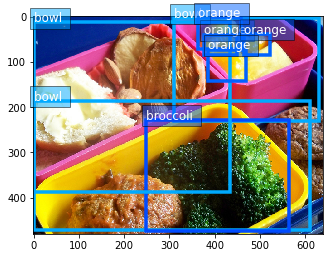

In [3]:
# Running the tutorial on reading mscoco II
train_image, train_label = train_dataset[0]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]
print('Image size (height, width, RGB):', train_image.shape)
print('Num of objects:', bounding_boxes.shape[0])
print('Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):\n',
      bounding_boxes)
print('Class IDs (num_boxes, ):\n', class_ids)

utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores=None,
                    labels=class_ids, class_names=train_dataset.classes)
plt.show()

In [4]:
# extract only presence labels [exclude image segementation information]
labels_list = [labels[1][:,4:5].ravel() for labels in train_dataset]

In [5]:
# Convert to binary labels format
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binarized_labels = mlb.fit_transform(labels_list)

In [7]:
# format in pandas dataframe with columns as class names
labels_names = train_dataset.index_map
import operator
sorted_labels_names = sorted(labels_names.items(), key=operator.itemgetter(1))
sorted_names = [label_name[0] for label_name in sorted_labels_names]
labels_df = pd.DataFrame(binarized_labels,columns=sorted_names)
#labels_df.to_csv('Datasets/binarized_labels.csv')

In [8]:
# Check co-occurances between labels
def get_coocurances(labels_df, output_path = None):
    LABELS_LIST = labels_df.columns
    # Getting coocuarances
    coocurrances = pd.DataFrame(columns=labels_df.columns)
    coocurrances_normalized = pd.DataFrame(columns=labels_df.columns)
    for column in labels_df.columns:
        coocurrances[column] = labels_df[labels_df[column] == 1].sum()
        coocurrances_normalized[column] = labels_df[labels_df[column] == 1 ].sum()/labels_df[column].sum()
    coocurrances = coocurrances.T
    coocurrances_normalized = coocurrances_normalized.T
    coocurrances.values[[np.arange(coocurrances.shape[0])]*2] = 0
    # Plotting coocurances
    plt.figure(figsize=(30, 30));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'Number of track class coocurances', fontsize=34, ha='center')
    sn.heatmap(coocurrances, annot=False, annot_kws={"size": 24}, fmt='.0f', cmap=cmap);
    return coocurrances, coocurrances_normalized
    #plt.savefig(output_path + ".pdf", format="pdf")
    #plt.savefig(output_path + ".png")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


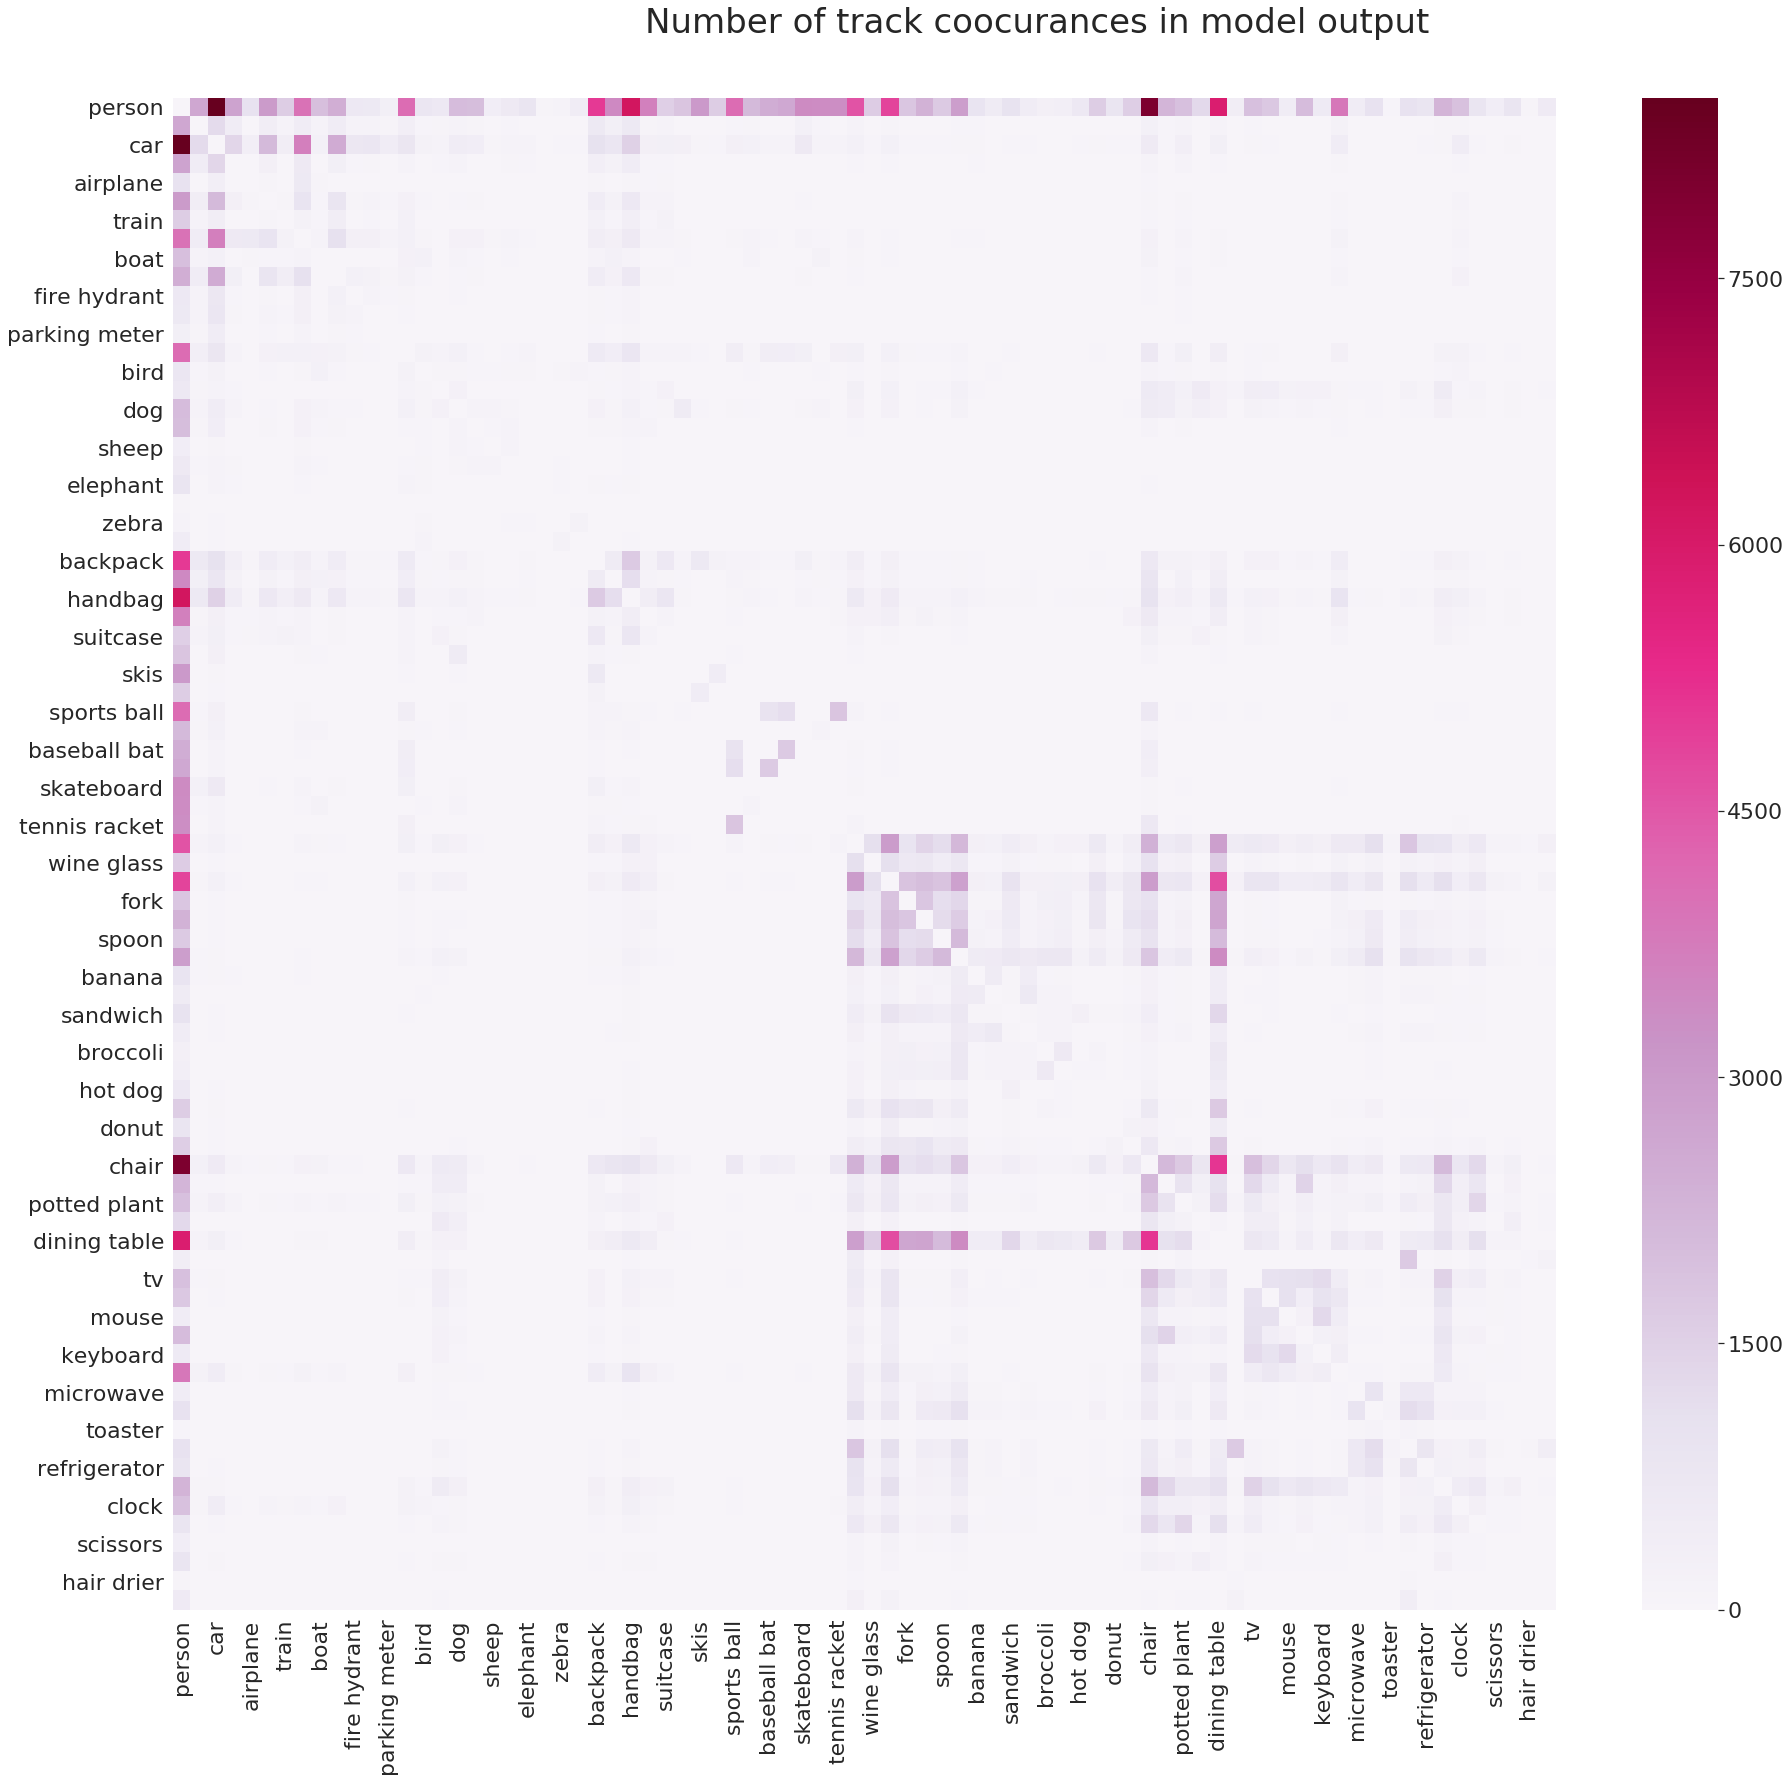

In [43]:
coocurrances, coocurrances_normalied = get_coocurances(labels_df)

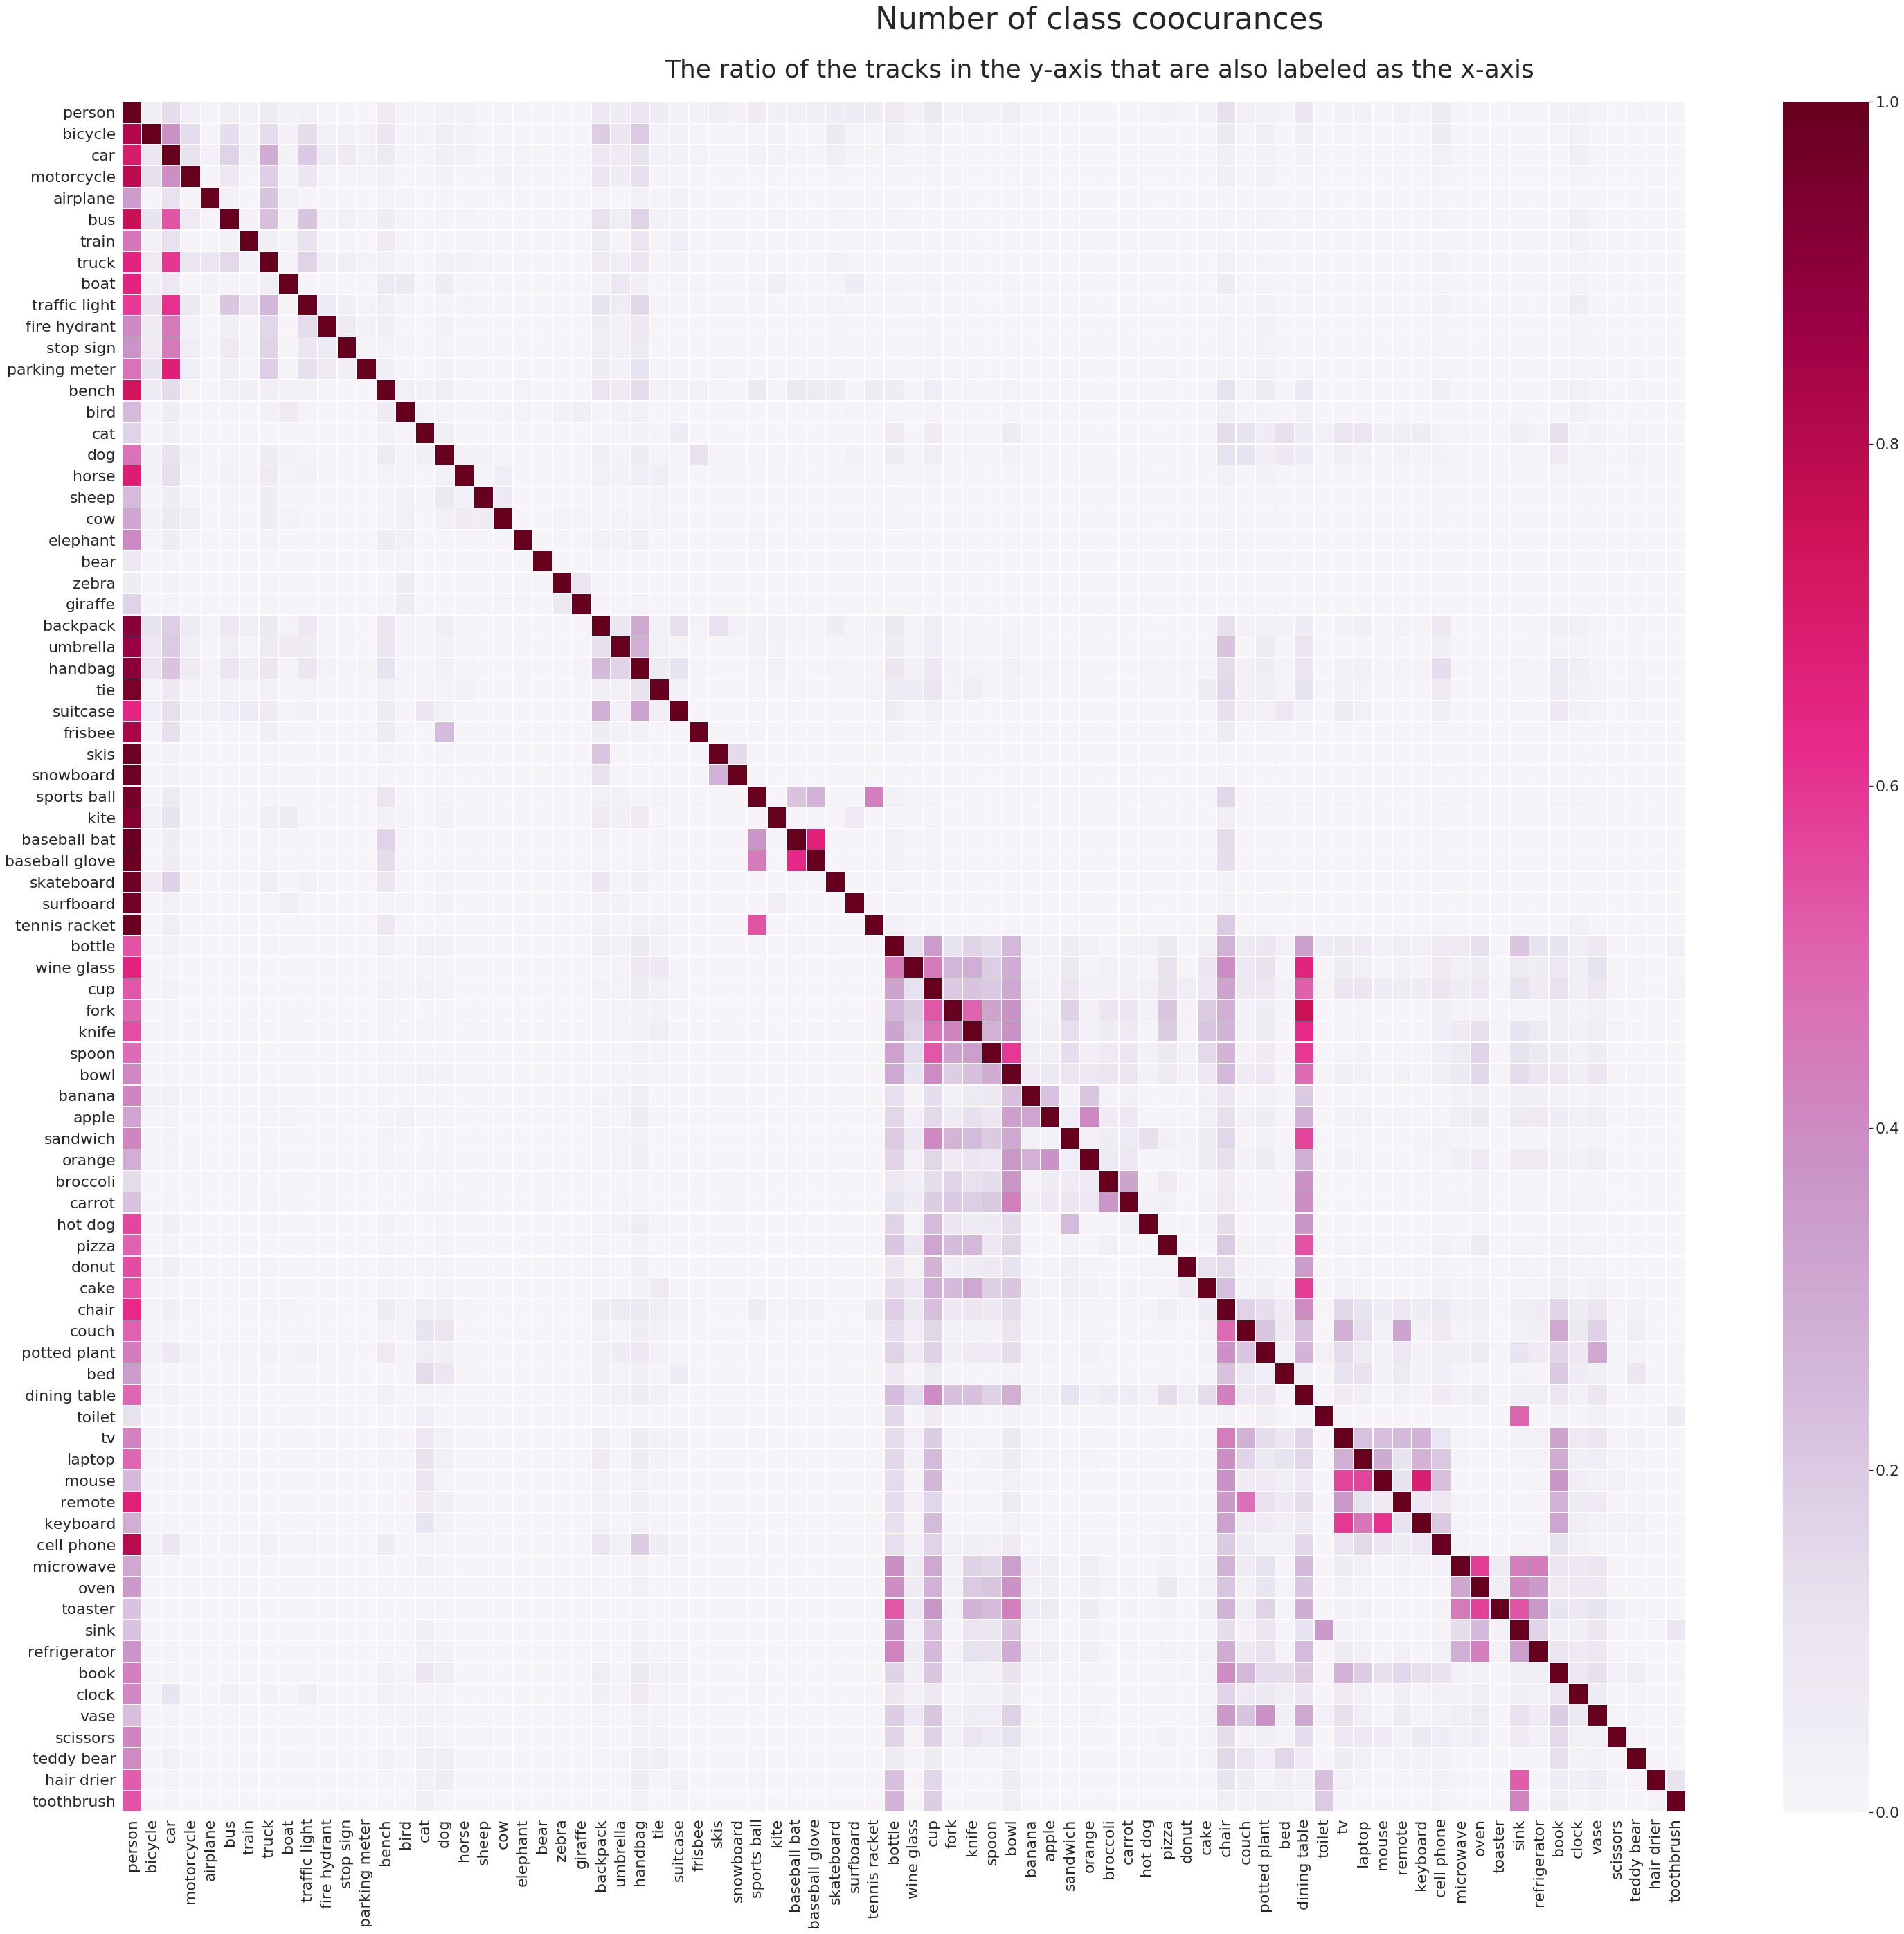

In [51]:
# Plotting coocurances normalized
plt.figure(figsize=(49, 49));
sn.set(font_scale=2)  # for label size
cmap = 'PuRd'
plt.axes([.1, .1, .8, .7])
plt.figtext(.5, .83, 'Number of class coocurances', fontsize=44, ha='center')
plt.figtext(.5,.81,'The ratio of the tracks in the y-axis that are also labeled as the x-axis',fontsize=36,ha='center')
sn.heatmap(coocurrances_normalied, annot=False, annot_kws={"size": 24}, fmt='.0f', cmap=cmap, linewidths=.5);

In [9]:
train_dataset[0][0].shape

(480, 640, 3)

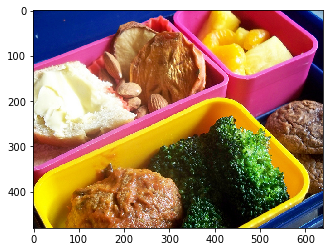

In [10]:
plt.imshow(train_dataset[0][0].asnumpy())

## Testing transfer learning from imagenet-trained network

In [6]:
import mxnet as mx
import numpy as np
import os, time, shutil

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs
from gluoncv.model_zoo import get_model

In [46]:
classes = 80

epochs = 5
lr = 0.001
per_device_batch_size = 32
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_gpus = 1
num_workers = 1
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

In [44]:
# format the image to match the model
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


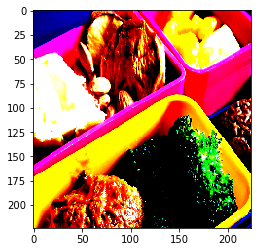

In [45]:
img = transform_test(train_dataset[0][0])
plt.imshow(nd.transpose(img, (1,2,0)).asnumpy())
plt.show()

In [38]:
#path = './minc-2500-tiny'
#train_path = os.path.join(path, 'train')
#val_path = os.path.join(path, 'val')
#test_path = os.path.join(path, 'test')

train_data = gluon.data.DataLoader(
    train_dataset.transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)


val_data = gluon.data.DataLoader(
    val_dataset.transform_first(transform_train),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)
'''
test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)
'''

'\ntest_data = gluon.data.DataLoader(\n    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),\n    batch_size=batch_size, shuffle=False, num_workers = num_workers)\n'

In [39]:
model_name = 'ResNet50_v2'
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier())
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
metric = mx.metric.Accuracy()
L = gluon.loss.SigmoidBinaryCrossEntropyLoss()

In [40]:
def test(net, val_data, ctx, counter = 0):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        counter += 1
        if counter > 1000: 
            break
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        binarized_label = nd.array(mlb.transform(label[0][0][:,4:5].asnumpy().T))
        outputs = [net(X) for X in data]
        metric.update(binarized_label, outputs)

    return metric.get()

In [ ]:
lr_counter = 0
num_batch = len(train_data)
for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1
    tic = time.time()
    train_loss = 0
    metric.reset()
    counter = 0
    for i, batch in enumerate(train_data):
        counter += 1
        if counter > 1000: 
            break
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        #plt.imshow(np.transpose(data[0][0], (1,2,0)).asnumpy())
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        #print(label[0][0][:,4:5])
        binarized_label = nd.array(mlb.transform(label[0][0][:,4:5].asnumpy().T))
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, binarized_label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(binarized_label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(finetune_net, val_data, ctx)

    print('[Epoch %d] Train-acc: %.3f, loss: %.37f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

#_, test_acc = test(finetune_net, test_data, ctx)
#print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.025, loss: 0.0014034188285892139781002585507962976 | Val-acc: 0.009 | time: 273.0
[Epoch 1] Train-acc: 0.006, loss: 0.0011861044694014412186067186638638304 | Val-acc: 0.006 | time: 274.6


In [65]:
np.load('/srv/workspace/research/mlml/datasets/mscoco/train_formatted_npz/10241.npz')['image']

array([[[20, 68, 82],
        [30, 68, 79],
        [26, 71, 77],
        ...,
        [25, 58, 65],
        [27, 60, 65],
        [ 9, 55, 71]],

       [[24, 73, 87],
        [37, 69, 84],
        [40, 72, 85],
        ...,
        [28, 51, 65],
        [21, 44, 60],
        [15, 61, 74]],

       [[27, 73, 89],
        [36, 75, 90],
        [27, 65, 76],
        ...,
        [16, 54, 67],
        [15, 67, 81],
        [16, 63, 73]],

       ...,

       [[ 2, 83, 64],
        [ 0, 81, 62],
        [ 0, 83, 63],
        ...,
        [ 9, 84, 79],
        [17, 85, 84],
        [21, 85, 85]],

       [[ 1, 82, 63],
        [ 0, 82, 62],
        [ 0, 83, 63],
        ...,
        [ 8, 89, 80],
        [13, 88, 83],
        [29, 85, 86]],

       [[ 1, 85, 62],
        [ 0, 84, 61],
        [ 0, 83, 65],
        ...,
        [11, 95, 82],
        [12, 89, 81],
        [30, 86, 85]]], dtype=uint8)

Exception in thread Thread-23:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/opt/conda/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/opt/conda/lib/python3.6/multiprocessing/pope